In [1]:
'''Classes for implementing reactions with respect to some set of reactant RDMols'''

from typing import ClassVar, Generator, Iterable, Optional, Union

from dataclasses import dataclass, field
from itertools import combinations, chain

from rdkit import Chem
from rdkit.Chem import rdqueries

from polymerist.rdutils.reactions.reactions import AnnotatedReaction, RxnProductInfo
from polymerist.rdutils import rdprops
from polymerist.rdutils.labeling import bondwise, molwise
from polymerist.rdutils.rdtypes import RDMol
from polymerist.monomers.specification import SANITIZE_AS_KEKULE


# CUSTOM QUERIES FOR ATOMS MODIFIED DURING A RXN
dummy_prop_query = rdqueries.HasPropQueryAtom('was_dummy') # heavy atom which was converted from a dummy atom in a reaction
HEAVY_FORMER_LINKER_QUERY = Chem.MolFromSmarts('A')
HEAVY_FORMER_LINKER_QUERY.GetAtomWithIdx(0).ExpandQuery(dummy_prop_query) # cast as Mol to allow for quick check via GetSubstructMatch


# REACTOR BASE CLASS 
@dataclass
class Reactor:
    '''Class for executing a reaction template on collections of RDMol "reactants"'''
    rxn_schema : AnnotatedReaction

    _has_reacted : bool = field(init=False, default=False)
    _ridx_prop_name : ClassVar[str] = field(init=False, default='reactant_idx') # name of the property to assign reactant indices to; set for entire class

    # PRE-REACTION PREPARATION METHODS
    def _activate_reaction(self) -> None:
        '''Check that the reaction schema provided is well defined and initialized'''
        pass

    def __post_init__(self) -> None:
        '''Pre-processing of reaction and reactant Mols'''
        self._activate_reaction()

    @classmethod
    def _label_reactants(cls, reactants : Iterable[RDMol]) -> None:
        '''Assigns "reactant_idx" Prop to all reactants to help track where atoms go during the reaction'''
        for i, reactant in enumerate(reactants):
            for atom in reactant.GetAtoms():
                atom.SetIntProp(cls._ridx_prop_name, i)

    # POST-REACTION CLEANUP METHODS
    @classmethod
    def _relabel_reacted_atoms(cls, product : RDMol, reactant_map_nums : dict[int, int]) -> None:
        '''Re-assigns "reactant_idx" Prop to modified reacted atoms to re-complete atom-to-reactant numbering'''
        for atom_id in rdprops.atom_ids_with_prop(product, 'old_mapno'):
            atom = product.GetAtomWithIdx(atom_id)
            map_num = atom.GetIntProp('old_mapno')

            atom.SetIntProp(cls._ridx_prop_name, reactant_map_nums[map_num])
            atom.SetAtomMapNum(map_num) # TOSELF : in future, might remove this (makes mapping significantly easier, but is ugly for labelling)

    @staticmethod
    def _sanitize_bond_orders(product : RDMol, product_template : RDMol, product_info : RxnProductInfo) -> None:
        '''Ensure bond order changes specified by the reaction are honored by RDKit'''
        for prod_bond_id, map_num_pair in product_info.mod_bond_ids_to_map_nums.items():
            target_bond = product_template.GetBondWithIdx(prod_bond_id)

            product_bond = bondwise.get_bond_by_map_num_pair(product, map_num_pair)
            # product_bond = product.GetBondBetweenAtoms(*rdlabels.atom_ids_by_map_nums(product, *map_num_pair))
            assert(product_bond.GetBeginAtom().HasProp('_ReactionDegreeChanged')) 
            assert(product_bond.GetEndAtom().HasProp('_ReactionDegreeChanged')) # double check that the reaction agrees that the bond has changed

            product_bond.SetBondType(target_bond.GetBondType()) # set bond type to what it *should* be from the reaction schema

    # REACTION EXECUTION METHODS
    def react(self, reactants : Iterable[RDMol], repetitions : int=1, clear_props : bool=False) -> list[RDMol]:
        '''Execute reaction over a collection of reactants and generate product molecule(s)'''
        self._label_reactants(reactants) # assign reactant indices in-place
        raw_products = self.rxn_schema.RunReactants(reactants, maxProducts=repetitions) # obtain unfiltered RDKit reaction output. TODO : generalize to work when more than 1 repetition is requested
        
        # post-reaction cleanup
        products = []
        for i, product in enumerate(chain.from_iterable(raw_products)): # clean up products into a usable form
            self._relabel_reacted_atoms(product, self.rxn_schema.map_nums_to_reactant_nums)
            self._sanitize_bond_orders(product,
                product_template=self.rxn_schema.GetProductTemplate(i),
                product_info=self.rxn_schema.product_info_maps[i]
            )
            if clear_props:
                rdprops.clear_atom_props(product, in_place=True)

            products.append(product)
        self._has_reacted = True # set reaction flag
        
        return products

# REACTOR SUBCLASSES
@dataclass
class AdditionReactor(Reactor):
    '''Special case of Reactor with two reactant species forming one product'''
    def __post_init__(self) -> None:
        assert(self.rxn_schema.GetNumReactantTemplates() == 2)
        assert(self.rxn_schema.GetNumProductTemplates() == 1)

        return super().__post_init__()
    
    @property
    def product_info(self) -> RDMol:
        return self.rxn_schema.product_info_maps[0]

    def react(self, reactants : Iterable[RDMol], repetitions : int = 1, clear_props : bool = False) -> Optional[RDMol]:
        products = super().react(reactants, repetitions, clear_props) # return first (and only) product as standalone molecule
        if products:
            return products[0]

@dataclass
class CondensationReactor(Reactor):
    '''Special case of Reactor with two reactant species forming one product plus a small-molecule side product'''
    pass # TODO : implement behavior here

In [2]:
from abc import ABC, abstractmethod, abstractproperty
from typing import Generator, Type

from polymerist.genutils.sequences import bin_ids_forming_sequence
from polymerist.rdutils.smileslib import queries
from polymerist.rdutils.rdtypes import RDMol
from polymerist.rdutils.reactions.reactions import RxnProductInfo


class NoIntermonomerBondsFound(Exception):
    '''To be raised when search for newly-formed inter-monomer bonds fail'''
    pass

class BadNumberOfFragmentsError(Exception):
    '''To be raised when more or fewer mol fragments are produced than expected'''
    pass

class ReactionTemplateMismatchError(Exception):
    '''To be raised when more or fewer mol fragments are produced than expected'''
    pass

class IntermonomerBondIdentificationStrategy(ABC):
    '''Abstract base for Intermonomer Bond Identification Strategies for fragmentation during in-silico polymerization'''
    def locate_intermonomer_bonds(self, product : RDMol, product_info : RxnProductInfo) -> Generator[int, None, None]:
        '''Generates the indices of all identified inter-monomer bonds by molecule'''
        pass

    def produce_fragments(self, product : RDMol, product_info : RxnProductInfo, separate : bool=True):
        '''Apply break all bonds identified by this IBIS algorithm and return the resulting fragments'''
        bid = list(self.locate_intermonomer_bonds(product, product_info)) # TODO : check that the multiplicity of any bond to cut is no greater than the bond order
        print(bid)
        fragments = Chem.FragmentOnBonds(product, bondIndices=bid)
        if separate:
            return Chem.GetMolFrags(fragments, asMols=True)
        return fragments # if separation is not requested, return as single unfragmented molecule object
IBIS = IntermonomerBondIdentificationStrategy # shorthand alias for convenience

class ReseparateRGroups(IBIS):
    '''IBIS which cleaves any new bonds formed between atoms that were
    formerly the start of an R-group in the reaction template'''
    def locate_intermonomer_bonds(self, product: RDMol,product_info : RxnProductInfo) -> Generator[int, None, None]:
        possible_bridgehead_ids = [atom_id for match in product.GetSubstructMatches(HEAVY_FORMER_LINKER_QUERY) for atom_id in match]
        for new_bond_id in product_info.new_bond_ids_to_map_nums.keys():                     # for each newly formed bond...
            print(new_bond_id)
            for bridgehead_id_pair in combinations(possible_bridgehead_ids, 2):                   # ...find the most direct path between bridgehead atoms...
                print('\t', bridgehead_id_pair)
                if new_bond_id in bondwise.get_shortest_path_bonds(product, *bridgehead_id_pair): # ...and check if the new bond lies along it
                    yield new_bond_id

@dataclass
class PolymerizationReactor(Reactor):
    '''Reactor which exhaustively generates monomers fragments according to a given a polymerization mechanism'''
    def propagate(self, monomers : Iterable[RDMol], fragment_strategy_type : Type[IntermonomerBondIdentificationStrategy]=ReseparateRGroups,
                   clear_map_nums : bool=True, count_steps_from : int=1) -> Generator[tuple[list[RDMol], list[RDMol]], None, None]:
        '''Keep reacting and fragmenting a pair of monomers until all reactive sites have been reacted
        Returns fragment pairs at each step of the chain propagation process'''
        reactant_templates_by_index = {i : reac_templ for i, reac_templ in enumerate(self.rxn_schema.GetReactants())}
        # num_reactants_in_mechanism = self.rxn_schema.GetNumReactantTemplates()
        num_reactants_in_mechanism = len(reactant_templates_by_index)
        
        ibis = fragment_strategy_type() # initialize fragmenter class
        
        polym_step = count_steps_from
        reactants = monomers # initialize reactive pair with monomers
        while True:
            intermediates = self.react(reactants, repetitions=1, clear_props=False) # can't clear properties yet, otherwise intermonomer bond finder would have nothing to go off of
            if not intermediates: # stop propagating once monomers can no longer react
                break

            fragment_info : list[tuple[RDMol, Generator[int, None, None]]] = []
            for i, product in enumerate(intermediates):
                Chem.SanitizeMol(product, sanitizeOps=SANITIZE_AS_KEKULE)
                if clear_map_nums:
                    product = molwise.clear_atom_map_nums(product, in_place=False) # TOSELF : could do this in-place, doing it out-of-place for now just to be safe
                
                product_fragments = ibis.produce_fragments(
                    product,
                    product_info=self.rxn_schema.product_info_maps[i],
                    separate=True
                )
                for fragment in product_fragments: # essential to avoid reaction mapping info from prior steps from contaminating future ones
                    rdprops.clear_atom_props(fragment, in_place=True)
                    matching_reactant_template_ids = list(queries.matching_labels_from_substruct_dict(fragment, reactant_templates_by_index))
                    fragment_info.append((fragment, matching_reactant_template_ids))

            # insert logic for re-mapping of fragments onto rxn
            fragments, fragment_template_ids = zip(*fragment_info)
            print(fragment_info)
            if len(fragments) != num_reactants_in_mechanism:
                raise BadNumberOfFragmentsError(f'Polymerization step {polym_step} produced {len(fragments)} fragments when {num_reactants_in_mechanism} were expected for the reaction')
            
            print(reactant_templates_by_index.keys(), fragment_template_ids)
            possible_fragment_orderings = bin_ids_forming_sequence(reactant_templates_by_index.keys(), fragment_template_ids) # generates all possible orders of the fragments which match the expected reactant templates for the reaction
            try:
                reactants = [fragments[i] for i in next(possible_fragment_orderings)] # get first valid ordering
            except StopIteration:
                yield intermediates, fragments
                break
                # raise ReactionTemplateMismatchError(f'Polymerization step {polym_step} fragments cannot be ordered to match the reactant templates specified in the {self.__class__.__name__} reaction schema')
            polym_step += 1 # increment step counter
            
            yield intermediates, reactants # yield the dimerized fragment and the 2 new reactive fragments

## Load rxn reference data

In [3]:
import json
import pandas as pd
from pathlib import Path

from polymerist.rdutils.reactions import reactions


# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

In [4]:
df = pd.read_csv(PROC_DATA_DIR / 'monomer_data_MASTER.csv', index_col=[0,1])
frames_by_mech = {
    mechanism : df.xs(mechanism)
        for mechanism in df.index.unique(level=0)
}

## Individual reaction

In [7]:
from polymerist.monomers import specification
from polymerist.rdutils.rdkdraw import set_rdkdraw_size
set_rdkdraw_size(300, 3/2)


mech = 'polyester'
# mech = 'polyurethane_isocyanate'
mech = 'polyimide'
mech = 'polyamide'
mech = 'polyurethane_nonisocyanate'
mech = 'vinyl'

frame = frames_by_mech[mech]
row = frame.iloc[3]
rxn = rxns[mech]
reactor = Reactor(rxn)
display(rxn)

reactants = []
for index in range(2):
    smi = row[f'smiles_monomer_{index}']
    exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smi, sanitize=False)
    display(mol)

    reactants.append(mol)

KeyError: 'vinyl'

12
	 (0, 11)
11
	 (0, 11)
[11]
[(<rdkit.Chem.rdchem.Mol object at 0x7f10c95fa6c0>, [0]), (<rdkit.Chem.rdchem.Mol object at 0x7f10c95fa880>, [1])]
dict_keys([0, 1]) ([0], [1])
==========STEP 0==========
Dimer 0


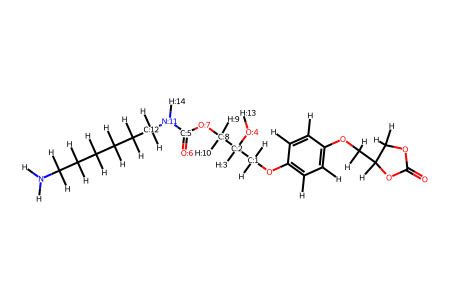

Fragment 0


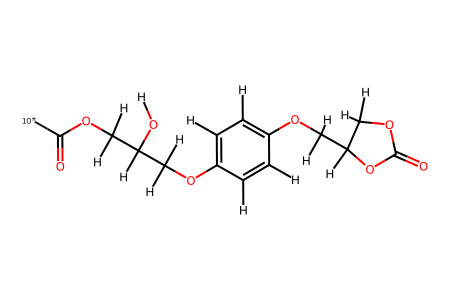

Fragment 1


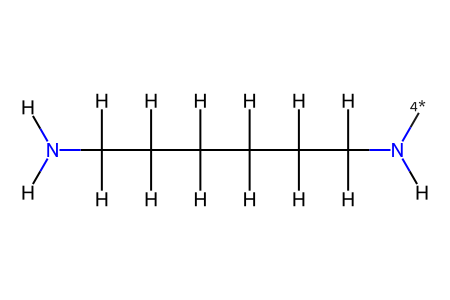

12
	 (0, 11)
11
	 (0, 11)
[11]
[(<rdkit.Chem.rdchem.Mol object at 0x7f10c95fa8f0>, []), (<rdkit.Chem.rdchem.Mol object at 0x7f10c95faab0>, [])]
dict_keys([0, 1]) ([], [])
==========STEP 1==========
Dimer 0


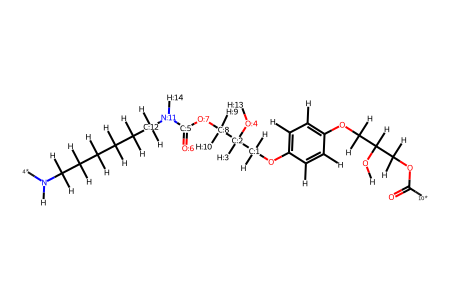

Fragment 0


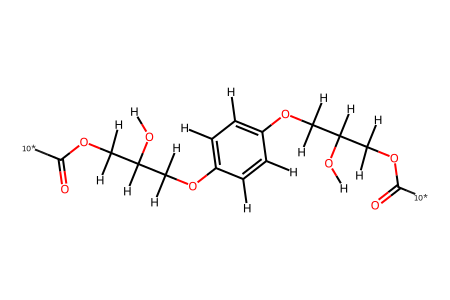

Fragment 1


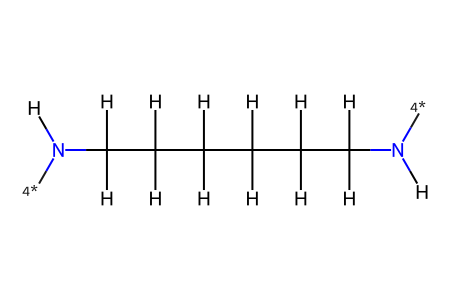

In [6]:
reactor = PolymerizationReactor(rxn)

BUFFER = '='*10
for i, (dimers, frags) in enumerate(reactor.propagate(reactants)):
    print(f'{BUFFER}STEP {i}{BUFFER}')
    for j, dim in enumerate(dimers):
        print(f'Dimer {j}')
        display(dim)
    bins = []
    for j, frag in enumerate(frags):
        print(f'Fragment {j}')
        display(frag)